## Northwest Georgia Housing Market

This analysis uses public Redfin data to predict how long single-family homes in Northwest Georgia will stay on the market and when sellers should adjust prices. After cleaning the dataset—dropping year-over-year columns, imputing missing price-cut values, and removing extreme outliers. Linear Regression and a tuned Random Forest model was ran. The model was paird with survival curve analysis to show key milestones at 15, 30, and 60 days, where buyer interest changes sharply. County level dashboards translate the results into clear, data-driven guidance on listing price, timing of cuts, and marketing strategy.

In [1]:
#Packages
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Data Preparation

In [2]:
# Read Housing Data
data = pd.read_csv("/Users/Malloryh5/Downloads/pj_1_fn_cl.tsv000", sep='\t')

In [3]:
# Spilt state and city
data[['County', 'State']] = data['REGION_NAME'].str.split(', ', expand=True)

In [4]:
# Drop all states, but Georgia
data_1 = data[data['State'] == 'GA']

In [5]:
#Drop any duplicates
data_1 = data_1.drop_duplicates()

In [6]:
# Make list of all columns ending in yoy. They have a lot of missing data.
yoy_drop = [col for col in data_1.columns if col.endswith('YOY')]

In [7]:
# Drop Columns ending in YOY
data_2 = data_1.drop(columns=yoy_drop)

In [8]:
# Find the est sqft
data_2['Est SqFt'] = data_2['MEDIAN_NEW_LISTING_PRICE'] / data_2['MEDIAN_NEW_LISTING_PPSF']

In [9]:
# Drop missing state data
data_2 = data_2[data_2['State'].notna()]

In [10]:
# Strip city
data_2['County'] = data_2['County'].str.upper().str.strip()

In [11]:
# Remove county and whitespace
data_2['County'] = data_2['County'].str.replace('COUNTY', '', case=False).str.strip()

In [12]:
# Northwest Georgia counties. Pulled from a county map.
counties_keep = ["DADE", "CATOOSA", "FANNIN", "UNION", "GILMER", "MURRAY", "WHITFIELD", "WALKER",
                 "CHATTOOGA", "FLOYD", "GORDON", "BARTOW", "PICKENS", "DAWSON", "LUMPKIN", "FORSYTH", 
                 "CHEROKEE"]

In [13]:
# Filter to just the selected counties
data_3 = data_2[data_2['County'].isin(counties_keep)]

In [14]:
#Drop columns with alot of NA
data_3 = data_3.drop(["MEDIAN_PENDING_SQFT", "OFF_MARKET_IN_TWO_WEEKS"], axis=1)
# Drop rows with NAs

In [15]:
# Mark if percent active with price drop is NA
data_3['PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS_missing'] = data_3[
    'PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS'].isnull().astype(int)

In [16]:
# Save median to replace NAs with median
med_price_drop = data_3['PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS'].median()

In [17]:
# Replace median with price drop
data_3['PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS'] = data_3[
    'PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS'].fillna(0)

In [18]:
# Drop Nas
data_cl = data_3.dropna()

In [21]:
# rows just before dropna
rows_before = data_3.shape[0]

# rows after dropping every row with at least one NA
data_cl = data_3.dropna()
rows_after  = data_cl.shape[0]

percent_dropped = (rows_before - rows_after) / rows_before * 100
print(f"{percent_dropped:.1f}% of rows were dropped")


0.5% of rows were dropped


### Data Modeling

### Days On The Market (DOM) - Regression Model

 ##### Linear Regression

In [19]:
# Make copy to prevent error
data_dom = data_cl.copy()

In [20]:
# Define features and targets to predict DOM
indepen_var = ['MEDIAN_SALE_PRICE', 'MEDIAN_NEW_LISTING_PPSF', 'ACTIVE_LISTINGS', 'MONTHS_OF_SUPPLY',
    'Est SqFt', 'PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS_missing']
depen_var = 'MEDIAN_DAYS_ON_MARKET'

In [21]:
# Assign variables to X and Y
X = data_dom[indepen_var]
y = data_dom[depen_var]

In [22]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#Allor Linear Regression
lr_model = LinearRegression()

In [73]:
# Fit model
lr_model.fit(X_train, y_train);

In [25]:
# Predict model
y_pred = lr_model.predict(X_test)

In [26]:
print("Linear Regression:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

Linear Regression:
MAE: 46.41328221120895
RMSE: 168.46693269972425
R² Score: 0.04783820686778684


***Notes:***
 - MAE: High, off by about 46 days
 - RMSE: High, 168 days off on average
 - R^2: Low, only explains about 5%

In [27]:
# Remove high DOM (anything more than 1 years)
data_dom_1 = data_dom[data_dom['MEDIAN_DAYS_ON_MARKET'] < 365]

In [28]:
# Assign variables to X and Y
X = data_dom_1[indepen_var]
y = data_dom_1[depen_var]

In [29]:
# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

In [72]:
# Fit Model
lr_model.fit(X_train, y_train);

In [31]:
# Predict model
y_pred = lr_model.predict(X_test)

##### Graph - Scatter Plot 1

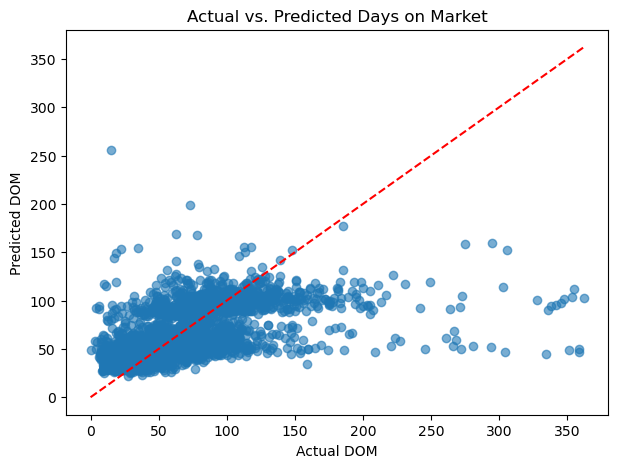

In [32]:
# Figure size
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual DOM')
plt.ylabel('Predicted DOM')
plt.title('Actual vs. Predicted Days on Market')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [33]:
print("Linear Regression: (Remove Outliers)")
print("MAE", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

Linear Regression: (Remove Outliers)
MAE 21.111873902776495
RMSE: 32.96174926161096
R² Score: 0.3531702249743197


***Notes:***
 - MAE: High, off by about 21 days
 - RMSE: High, 32 days off on average
 - R^2: Low, only explains about 35%
 - Better, but still not great. Data is not very liner, try random forest

#### Random Forest

In [34]:
# Allow random forest
rf_model = RandomForestRegressor(random_state=42)

In [71]:
# Fit model
rf_model.fit(X_train, y_train);

In [36]:
# Predict model
y_pred_rf = rf_model.predict(X_test)

In [37]:
print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest
MAE: 14.914612877764679
RMSE: 25.970989962693853
R2: 0.5984436396261217


***Notes:***
 - MAE: Off by about 14 days
 - RMSE: 25 days off on average
 - R^2: Explains about 60%
 - Better, test grid search to see if it will improve

In [38]:
# See it can be improved more
para_grid = {'n_estimators': [100, 200, 300, 400],
             'max_depth': [None, 10, 20, 30, 40, 50],
             'min_samples_leaf': [1, 2, 4, 8],
             'max_features': [None, 'sqrt', 'log2'],
             'bootstrap' : [True, False]
              }

In [39]:
# Grid Search. Use randomized search. 
gr_sch_rf = RandomizedSearchCV(rf_model, para_grid, cv=3, verbose=0);

In [70]:
# Fit model
gr_sch_rf.fit(X_train, y_train);

In [41]:
# Save results
best_rf = gr_sch_rf.best_estimator_
y_pred = best_rf.predict(X_test)

In [42]:
print("Best parameters:", best_rf)
print("Tuned MAE:", mean_absolute_error(y_test, y_pred))
print("Tuned RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Tuned R2:", r2_score(y_test, y_pred))

Best parameters: RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=400,
                      random_state=42)
Tuned MAE: 14.83659551319585
Tuned RMSE: 25.88106955438898
Tuned R2: 0.601219475483467


***Notes:***
 - MAE: Lower, off by about 11 days
 - RMSE: Lower, 22 days off on average
 - R^2: Higher, only explains about 71%
 - Better, results

In [43]:
# Check for overfitting
train_pred = best_rf.predict(X_train)
test_pred = best_rf.predict(X_test)

In [44]:
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test MAE:", mean_absolute_error(y_test, test_pred))

Train MAE: 5.567027425766299
Test MAE: 14.83659551319585


***Notes:***
 - Reasonable results.

##### Graph - Scatter Plot 2

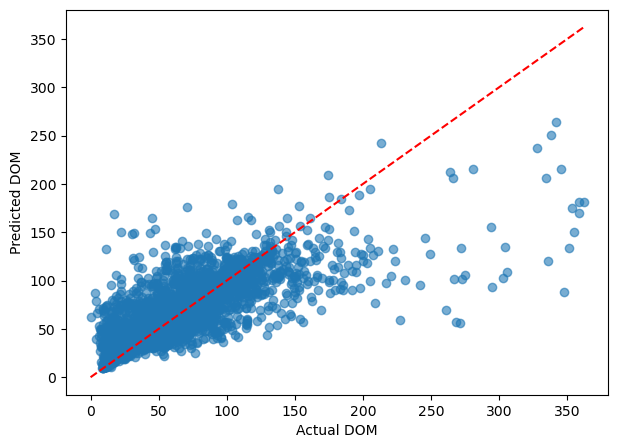

In [45]:
# Plot Size
plt.figure(figsize=(7, 5))
#Scatter Plot
plt.scatter(y_test, y_pred, alpha=0.6)
# X-axis
plt.xlabel('Actual DOM')
# Y-axis
plt.ylabel('Predicted DOM')
# Plot Data
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# Show graph
plt.show()

### Predict Results - DOM by County

In [46]:
# Group by count and find mean
county_mean = data_dom.groupby('County')[indepen_var].mean()

In [47]:
# Predict DOM for each county in northwest Georgia
pred_dom_county = best_rf.predict(county_mean)

In [48]:
# Save predicted DOM as a column
county_mean['Predicted_DOM'] = pred_dom_county

In [49]:
# Sort the values from low to high
county_mean = county_mean[['Predicted_DOM']].sort_values('Predicted_DOM')

In [50]:
print(county_mean)

           Predicted_DOM
County                  
FORSYTH        31.026875
CHEROKEE       38.623889
GORDON         39.968024
DAWSON         42.064868
GILMER         42.264896
FLOYD          43.343687
WHITFIELD      44.295875
CATOOSA        45.075875
MURRAY         52.494967
LUMPKIN        53.435937
UNION          54.066155
FANNIN         54.232899
WALKER         54.748895
BARTOW         55.820114
PICKENS        59.423991
CHATTOOGA      75.192795
DADE          109.509987


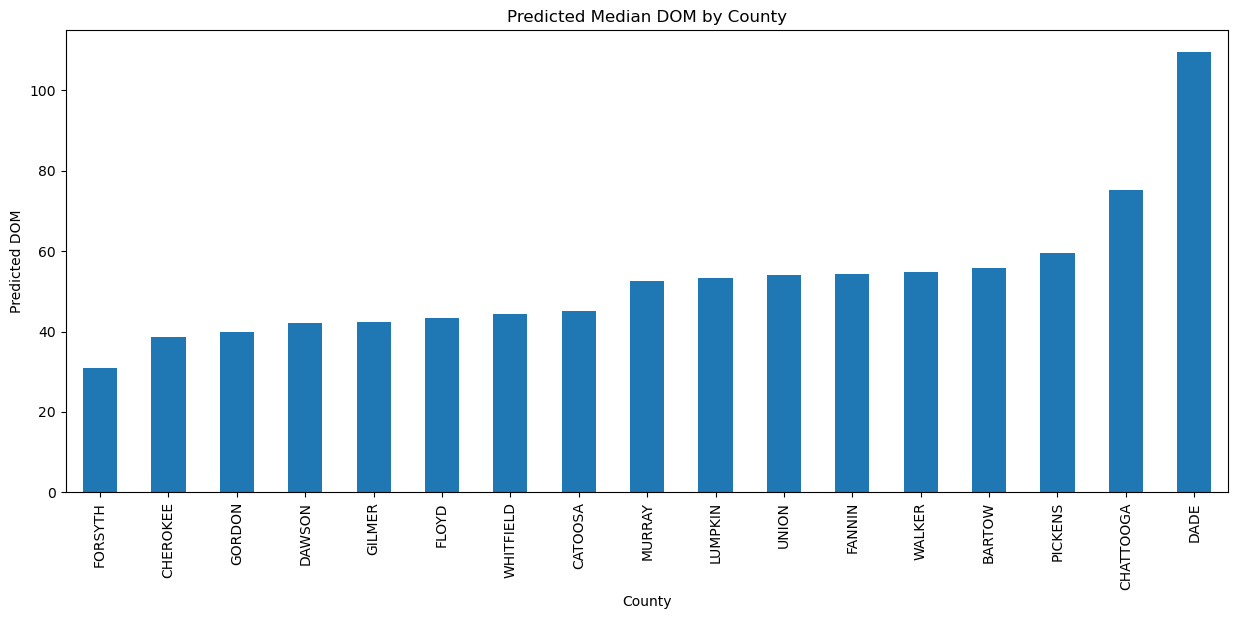

In [51]:
# Plot Size
plt.figure(figsize=(15, 6))
#Bar graph
county_mean['Predicted_DOM'].plot(kind='bar')
# Title
plt.title('Predicted Median DOM by County')
# Y-axis
plt.ylabel('Predicted DOM')
#Show graph
plt.show()

### Days On The Market - Survival Curve

In [52]:
# Create bins and labels for bins
bins = [0, 15, 30, 45, 60, 100, 365]
labels = ['<=15', '16-30', '31-45', '46-60', '61-100', '100+']

In [53]:
# Group by bins and label
data_dom['DOM_bin'] = pd.cut(data_dom['MEDIAN_DAYS_ON_MARKET'], bins=bins, labels=labels)

In [54]:
# find the the number of houses on the the market for each bin
dom_counts = data_dom['DOM_bin'].value_counts().sort_index(ascending=True)

In [55]:
# Make it a percent. Precent of homes unsold after each period
dom_percent = 1 - dom_counts.cumsum() / dom_counts.sum()

##### Graph - Step Plot

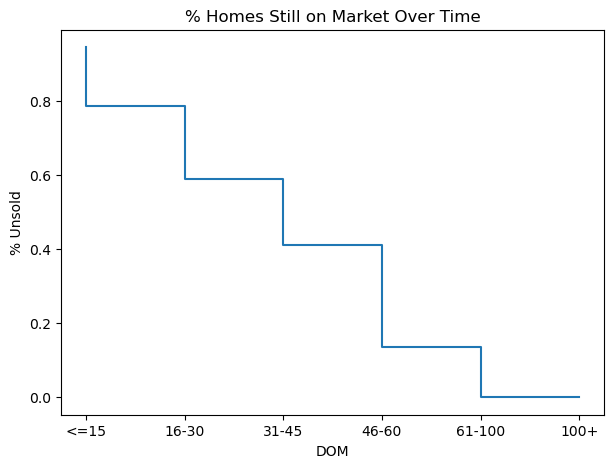

In [56]:
# figure size
plt.figure(figsize=(7,5))
#Plot data
plt.step(labels, dom_percent)
# Title
plt.title('% Homes Still on Market Over Time')
# Y-axis
plt.ylabel('% Unsold')
# X-axis
plt.xlabel('DOM')
#Print graph
plt.show()

***Notes:***
 - 20% sell in the first 15 days, and 40% by day 30.
 - Largest drop between 31–60 days
 - After two months, only a small amount of homes are left
 

### Potential Price Drop

In [57]:
# price drop % per county
county_pr_drops = data_dom.groupby('County')['PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS'].mean().sort_values(ascending=False)

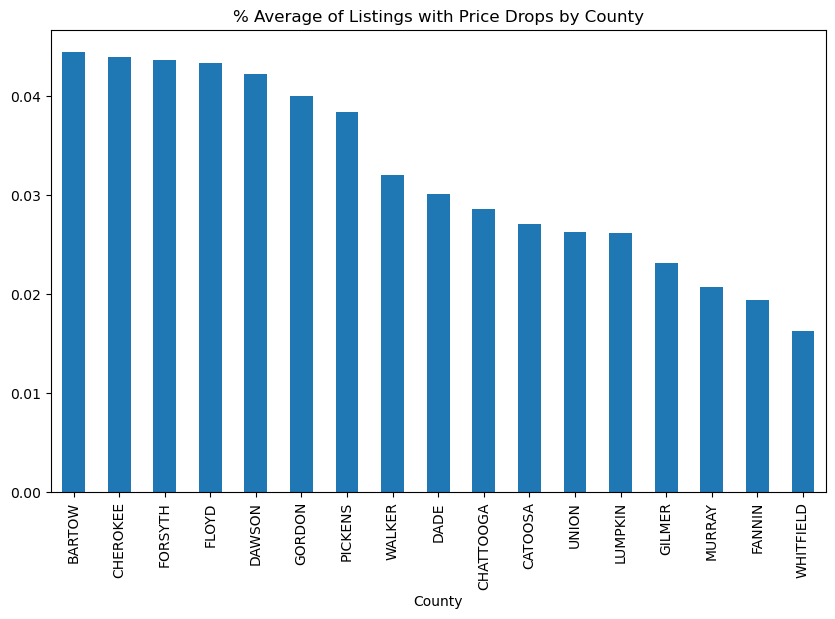

In [58]:
# Figure size
plt.figure(figsize=(10,6))
# Bar chart
county_pr_drops.plot(kind='bar')
# Title
plt.title('% Average of Listings with Price Drops by County')
# Print graph
plt.show()

#### Time to price cut and average % price drop by county

In [59]:
data_dom_2 = data_dom.copy()

In [60]:
# Make a classification column
data_dom_2['price drop occurred'] = (data_dom['PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS'] > 0).astype(int)

In [61]:
#Group by county % dropped
cut_pc_county = data_dom_2.groupby('County')['PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS'].mean()

In [62]:
print("Average price cut % by region:\n", cut_pc_county)

Average price cut % by region:
 County
BARTOW       0.044430
CATOOSA      0.027070
CHATTOOGA    0.028637
CHEROKEE     0.043945
DADE         0.030109
DAWSON       0.042211
FANNIN       0.019381
FLOYD        0.043298
FORSYTH      0.043603
GILMER       0.023134
GORDON       0.040035
LUMPKIN      0.026192
MURRAY       0.020685
PICKENS      0.038421
UNION        0.026264
WALKER       0.032044
WHITFIELD    0.016249
Name: PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS, dtype: float64


In [65]:
# Average sale to list by county
county_ratio = data_cl.groupby('County')['AVERAGE_SALE_TO_LIST_RATIO'].mean().sort_values()

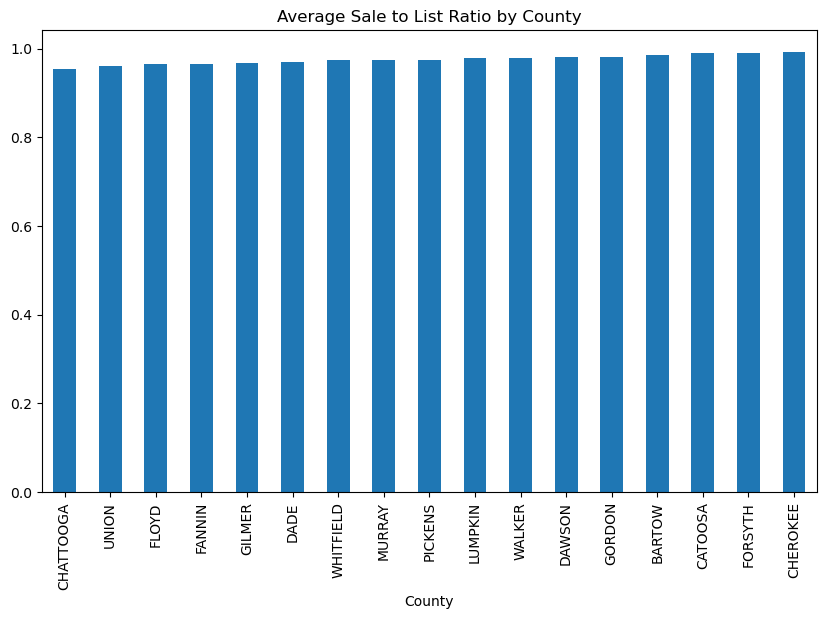

In [66]:
#Figure size
plt.figure(figsize=(10,6))
# Bar Plot
county_ratio.plot(kind='bar')
# Title
plt.title('Average Sale to List Ratio by County')
# Print graph
plt.show()

In [67]:
# show discount percent
discount_county = (1 - county_ratio) * 100

In [68]:
print(discount_county)

County
CHATTOOGA    4.673688
UNION        3.840267
FLOYD        3.550304
FANNIN       3.481709
GILMER       3.216448
DADE         2.989302
WHITFIELD    2.584216
MURRAY       2.544881
PICKENS      2.530940
LUMPKIN      2.197722
WALKER       2.083081
DAWSON       1.963104
GORDON       1.856008
BARTOW       1.363031
CATOOSA      0.995175
FORSYTH      0.890376
CHEROKEE     0.815187
Name: AVERAGE_SALE_TO_LIST_RATIO, dtype: float64


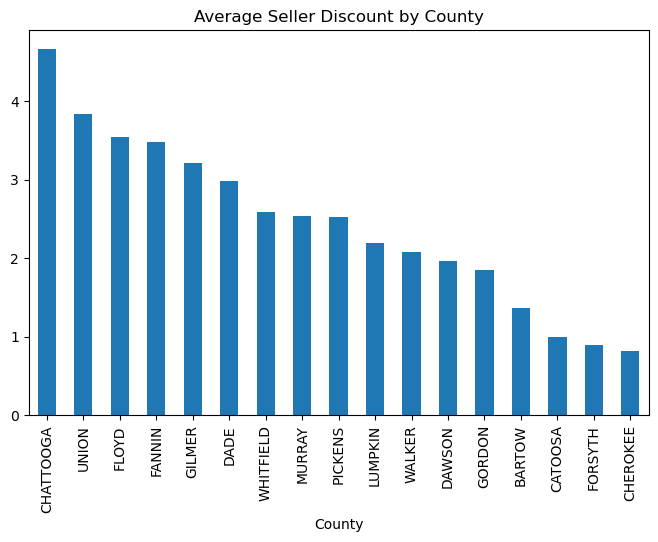

In [69]:
# Figures and size
discount_county.plot(kind='bar', figsize=(8,5))
# Title
plt.title('Average Seller Discount by County')
# Print Graph
plt.show()